# Expenses Tracker Using AI and ML

# Introduction 

Managing personal finances has become increasingly challenging as individuals deal with multiple income sources, growing expenses, digital transactions, and borrowing or lending activities. Many users lack the time, knowledge, or tools to manually track spending patterns or forecast their future financial needs, which often leads to poor budgeting decisions and unexpected financial stress. To address this problem, the proposed AI-Enhanced Personal Finance Manager integrates data analytics, machine learning, and an interactive web dashboard into a unified, user-friendly platform. The system automatically processes raw transaction data, categorizes expenses, computes monthly insights, and uses machine learning models such as Random Forest and Support Vector Regression to forecast future expenses, helping users plan ahead more effectively. The application includes intuitive visualizations such as income–expense charts and spending distribution graphs along with a smart AI finance assistant that provides personalized guidance, answers financial queries, and suggests budget improvements. Additionally, the system introduces a borrowing and lending management module, enabling both personal and professional users to track dues, repayments, and outstanding balances. By combining automation, predictive analytics, and conversational AI, this project offers a comprehensive solution that simplifies financial management, enhances user awareness, and improves decision-making through intelligent insights.

In [1]:
# Cell 1: imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib
import os

In [2]:
df = pd.read_excel("Dataset.xlsx")

print("Shape:", df.shape)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.head()
if "amount" not in df.columns:
    df["debit"] = pd.to_numeric(df.get("debit"), errors="coerce")
    df["credit"] = pd.to_numeric(df.get("credit"), errors="coerce")
    df["amount"] = df["credit"].fillna(0) - df["debit"].fillna(0)

# Make positive = income, negative = expense
df["is_income"] = (df["amount"] > 0).astype(int)
df["amount_abs"] = df["amount"].abs()
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
else:
    raise ValueError("No 'date' column found — please check column names.")
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.weekday  # 0 = Monday
df["month_number"] = df["month"]
cat_cols = ["category", "sub-category", "category_type"]

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()
df["year_month"] = df["date"].dt.to_period("M")
monthly = df.groupby("year_month").agg(
    total_expense = ("amount", lambda x: -x[x < 0].sum()),  # convert to positive
    total_income  = ("amount", lambda x: x[x > 0].sum()),
    trans_count   = ("amount", "count"),
    avg_trans     = ("amount_abs", "mean"),
    median_trans  = ("amount_abs", "median")
).reset_index()

# Convert to timestamp format
monthly["year_month"] = monthly["year_month"].dt.to_timestamp()
monthly = monthly.sort_values("year_month").reset_index(drop=True)

monthly.head()
# Next-month expense target
monthly["next_month_expense"] = monthly["total_expense"].shift(-1)

# Lagging expense (1 to 3 months)
for lag in [1, 2, 3]:
    monthly[f"exp_lag_{lag}"] = monthly["total_expense"].shift(lag)

# Expense-to-income ratio
monthly["expense_to_income"] = monthly["total_expense"] / (monthly["total_income"] + 1e-9)

# Frequency features
monthly["trans_per_income"] = monthly["trans_count"] / (monthly["total_income"] + 1e-9)

# Month cyclic encoding
monthly["month"] = monthly["year_month"].dt.month
monthly["month_sin"] = np.sin(2 * np.pi * monthly["month"] / 12)
monthly["month_cos"] = np.cos(2 * np.pi * monthly["month"] / 12)

# Drop rows with missing targets
monthly = monthly.dropna(subset=["next_month_expense"]).reset_index(drop=True)

monthly.head()

Shape: (486, 10)


,year_month,total_expense,total_income,trans_count,avg_trans,median_trans,next_month_expense,exp_lag_1,exp_lag_2,exp_lag_3,expense_to_income,trans_per_income,month,month_sin,month_cos
0,2021-01-01,2874.0,14000.0,47,359.021277,28.0,2904.6,NaN,NaN,NaN,0.205286,0.003357,1,0.500000,8.660254e-01
1,2021-02-01,2904.6,5800.0,46,189.230435,26.5,3049.7,2874.0,NaN,NaN,0.500793,0.007931,2,0.866025,5.000000e-01
2,2021-03-01,3049.7,6000.0,50,180.994000,20.0,3038.0,2904.6,2874.0,NaN,0.508283,0.008333,3,1.000000,6.123234e-17
3,2021-04-01,3038.0,7340.0,49,211.795918,15.1,3116.1,3049.7,2904.6,2874.0,0.413896,0.006676,4,0.866025,-5.000000e-01
4,2021-05-01,3116.1,6000.0,50,182.322000,21.7,3005.7,3038.0,3049.7,2904.6,0.519350,0.008333,5,0.500000,-8.660254e-01


In [4]:
features = [
    "total_expense", "total_income",
    "trans_count", "avg_trans", "median_trans",
    "exp_lag_1", "exp_lag_2", "exp_lag_3",
    "expense_to_income", "trans_per_income",
    "month_sin", "month_cos"
]

target = "next_month_expense"

X = monthly[features]
y = monthly[target]

split_point = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, features)]
)

# Random Forest pipeline
rf = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_rmse = mean_squared_error(y_test, rf_pred) ** 0.5

print("\n--- RANDOM FOREST RESULTS ---")
print("RF MAE:", mean_absolute_error(y_test, rf_pred))
print("RF RMSE:", rf_rmse)
# print("RF R2:", r2_score(y_test, rf_pred))

# svr pipeline
svr = Pipeline([
    ("preprocess", preprocessor),
    ("model", SVR(kernel="rbf", C=100, gamma="scale"))
])

svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

svr_rmse = mean_squared_error(y_test, svr_pred) ** 0.5

print("\n--- SVR RESULTS ---")
print("SVR MAE:", mean_absolute_error(y_test, svr_pred))
print("SVR RMSE:", svr_rmse)
# print("SVR R2:", r2_score(y_test, svr_pred))

Train size: (7, 12)
Test size: (2, 12)

--- RANDOM FOREST RESULTS ---
RF MAE: 82.8861666666769
RF RMSE: 87.05387564447688

--- SVR RESULTS ---
SVR MAE: 96.92045391509532
SVR RMSE: 98.24694066776775


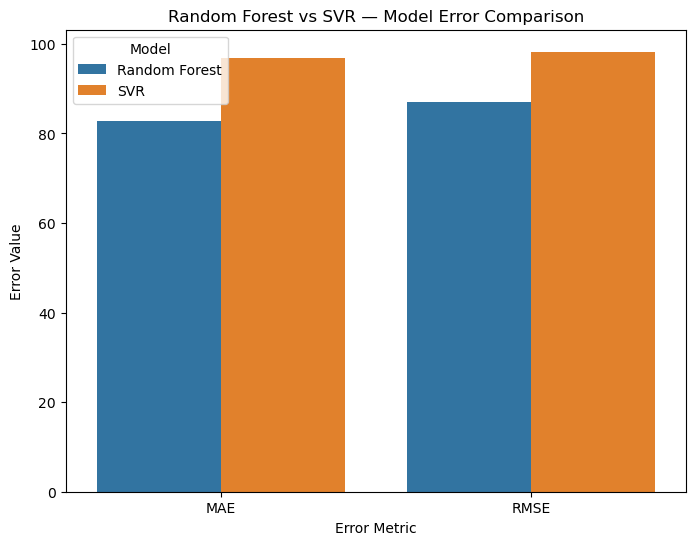

In [5]:
results = pd.DataFrame({
    'Metric': ['MAE', 'RMSE'],
    'Random Forest': [82.8861666666769, 87.05387564447688],
    'SVR': [96.92045391509532, 98.24694066776775]
})

# Melt for seaborn plotting
results_melted = results.melt(id_vars='Metric', 
                              var_name='Model', 
                              value_name='Value')

plt.figure(figsize=(8,6))
sns.barplot(data=results_melted, x='Metric', y='Value', hue='Model')
plt.title("Random Forest vs SVR — Model Error Comparison")
plt.xlabel("Error Metric")
plt.ylabel("Error Value")
plt.legend(title="Model")
plt.show()

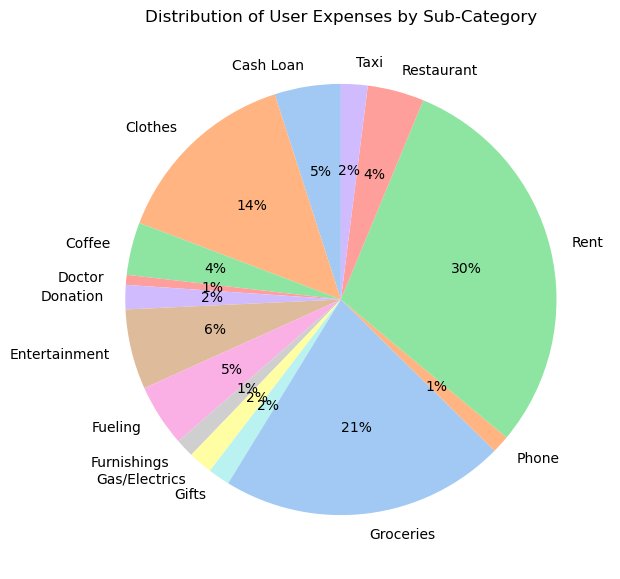

In [6]:
plt.figure(figsize=(7,7))

expense_sums = df[df['is_income']==0].groupby('sub-category')['amount_abs'].sum()

plt.pie(
    expense_sums.values, 
    labels=expense_sums.index,
    autopct='%1.0f%%',
    startangle=90,
    colors=sns.color_palette('pastel')
)

plt.title("Distribution of User Expenses by Sub-Category")
plt.show()

In [9]:
# Load the trained model
model = joblib.load("models/random_forest_pipeline.pkl")

# Define new input data with ALL required columns
new_input = pd.DataFrame({
    'debit': [0],
    'credit': [5000],
    'month_number': [11],
    'amount': [5000],
    'is_income': [1],
    'trans_per_income': [1],
    'exp_lag_1': [0],
    'total_income': [5000],
    'trans_count': [1],
    'total_expense': [0],
    'exp_lag_3': [0],
    'avg_trans': [5000],
    'month_sin': [0.91],
    'median_trans': [5000],
    'month_cos': [0.41],
    'expense_to_income': [0],
    'exp_lag_2': [0]
})

# Make prediction
pred = model.predict(new_input)

print("Prediction:", pred)

Prediction: [3007.63866667]


# UI and UX Integration
https://ai-personal-finance-zuf9.bolt.host/

# Conclusion 

1 Effective Financial Forecasting:
The system accurately analyzes user transactions through intelligent preprocessing and feature engineering, with Random Forest emerging as the best-performing model based on MAE and RMSE, offering reliable next-month expense predictions.

2 Improved Budget Awareness:
By providing clear visual insights such as monthly income vs. expense trends and category-wise spending the interactive dashboard helps users understand their financial behavior instantly and make more informed budgeting decisions.

3 Enhanced User Experience:
The integrated AI chatbot assistant adds significant value by offering personalized financial advice, answering queries, detecting overspending patterns, and helping users plan savings or manage borrowing/lending activities.

4 Complete Smart Finance Solution:
Combining machine learning forecasting, rich visualizations, and conversational AI, the system delivers a comprehensive, user-friendly platform that empowers individuals to manage their finances efficiently, avoid financial stress, and plan for the future with confidence.